In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../scripts')
from simulation import *

In [3]:
N = 80000
p = 0.005
K = N*p
P = 16
tau = 0.01
dt = 1e-3
A = 2
theta = 0
sigma = 0.1

In [4]:
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N))

In [5]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N, p, size=N)
ji = build_ji(k, N)

100%|██████████| 80000/80000 [01:54<00:00, 697.06it/s]


In [6]:
# Store pattern associations using the bilinear plasticity rule
plasticity = BilinearPlasticityRule()
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=1)

100%|██████████| 80000/80000 [00:05<00:00, 15074.51it/s]


In [7]:
# Adjust subpopulation weights
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, 
         A, N, w_11=1, w_12=1, w_21=0, w_22=0)
reweight(indptr, indices, data_p0_copy,
         A, N, w_11=0, w_12=0, w_21=1, w_22=1)
data = data_p1_copy + data_p0_copy
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N,N),
    dtype=cp.float32)

80000it [00:00, 139413.39it/s]
80000it [00:00, 140101.31it/s]


In [8]:
# Sanity check: visualize a single sample run 
r = simulate(
    T=0.5,
    dt=1e-3,
    tau=0.01,
    N=N,
    I_ext_1=-0.2,
    I_ext_2=-1,
    theta=theta,
    sigma=sigma,
    patterns=patterns,
    W=W)
q, q1, q2 = correlations(r, patterns, individual=True)

100%|██████████| 499/499 [00:01<00:00, 326.13it/s]


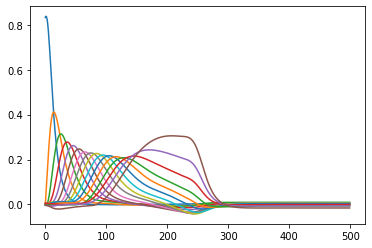

In [10]:
import matplotlib.pyplot as plt
for m in q:
    plt.plot(m);

In [11]:
def quality(q):
    try:
        return q[-1,:].max()
    except:
        return np.NaN
    
def speed(q, tau, dt):
    try:
        idxs = q.argmax(axis=1)
        diffs = np.diff(idxs)
        diffs = diffs[np.logical_and(
            np.logical_and(
                diffs < diffs.mean()+2*diffs.std(),
                diffs > diffs.mean()-2*diffs.std()),
            diffs > 0)]
        return tau/dt/np.mean(diffs)
    except:
        return np.NaN

In [25]:
# Desired speed
s_target = 0.3

# Starting input
I_ext = np.asarray([-0.2,-0.2], dtype=np.float32)
I_ext_delta = np.asarray([0,0], dtype=np.float32)
v_A = 0.1

R_history = []
I_ext_1_history = [I_ext[0]]
I_ext_2_history = [I_ext[1]]

while True:
    r = simulate(
        T=0.5,
        dt=1e-3,
        tau=tau,
        N=N,
        I_ext_1=np.clip(I_ext[0]+I_ext_delta[0], a_min=None, a_max=0),
        I_ext_2=np.clip(I_ext[1]+I_ext_delta[1], a_min=None, a_max=0),
        theta=theta,
        sigma=sigma,
        patterns=patterns,
        W=W,
        disable_pbar=True)
    m, _, _ = correlations(r, patterns, individual=False)
    s = speed(m, tau, dt)
    q = quality(m)
    
    # Reward signal
    R = 1/np.abs(s - s_target)*int(q>0.05)
    if R != 0 and R < 0.01:
        break
        
    if len(R_history) == 0:
        R_history.append(R)
    else:
        # If reward signal increased, and quality is above threshold,
        # lock in change
        if q > 0.05 and R > R_history[-1]:
            print("Locking in input change")
            I_ext += I_ext_delta
            I_ext_1_history.append(I_ext[0])
            I_ext_2_history.append(I_ext[1])
            R_history.append(R)
        
    # Perturb input vector
    I_ext_delta[:] = v_A * (1-2*np.random.rand(2))
    print("Perturbing input vector by (%f, %f)" % (I_ext_delta[0], I_ext_delta[1]))
    print("Speed %f, quality %f, I_ext (%f, %f)" % (s, q, I_ext[0], I_ext[1]))

Perturbing input vector by (-0.081951, -0.054822)
Speed 0.457746, quality 0.554449, I_ext (-0.200000, -0.200000)
Locking in input change
Perturbing input vector by (0.072614, -0.065481)
Speed 0.414201, quality 0.556147, I_ext (-0.281951, -0.254822)
Perturbing input vector by (0.069702, 0.024060)
Speed 0.469314, quality 0.550856, I_ext (-0.281951, -0.254822)
Perturbing input vector by (-0.038729, 0.026064)
Speed 0.459364, quality 0.554771, I_ext (-0.281951, -0.254822)
Locking in input change
Perturbing input vector by (0.095212, 0.096251)
Speed 0.406977, quality 0.555467, I_ext (-0.320679, -0.228757)
Perturbing input vector by (0.013558, 0.042909)
Speed 0.410557, quality 0.555364, I_ext (-0.320679, -0.228757)
Locking in input change
Perturbing input vector by (0.050269, 0.032641)
Speed 0.405797, quality 0.556161, I_ext (-0.307121, -0.185849)
Perturbing input vector by (-0.051198, 0.015216)
Speed 0.409357, quality 0.556504, I_ext (-0.307121, -0.185849)
Locking in input change
Perturbing 

KeyboardInterrupt: 

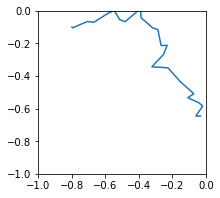

In [46]:
plt.figure(figsize=(3,3))
plt.plot(I_ext_2_history, I_ext_1_history)
plt.ylim([-1,0])
plt.xlim([-1,0]);

In [26]:
np.save("6-reward-driven/data/I_ext_v1.npy", [I_ext_2_history, I_ext_1_history])